In [101]:
import simsz.make_dm_halo as make_dm_halo
import simsz.utils as utils
from simsz import simtools, noise, filters
import make_sz_cluster
import simsz.load_vars as load_vars
from colossus.halo import mass_adv

import time
from datetime import datetime as dt
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import h5py
from pixell import enmap, powspec, enplot
import camb

from astropy.constants import M_sun
from astropy.constants import G, sigma_T, m_e, c, h, k_B
from astropy import units as u

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


What this notebook currently does: 
- Reads in data from the sim run yaml
- Loads cosmology
- Generates and saves a flat redshift and Mvir distribution as a .txt file
- Loads an existing redshift and Mvir distribution from a .txt file

What this notebook could do, but currently doesn't:
- Generate/use M200 rather than convert from Mvir
- Save m, z dist as .h
- Generates a realistic z, M500 distribution from a given cosmology 

What the modules could be improved to do:
- Streamline the generation of z,M500 distributions by creating a function with options
- Save the z, M500 distribution at the function level in GenerateHalo.py

Problems to be addressed:
- Profile is oddly steep and needs to be checked with Battaglia 2012 realistic z,M, params

In [5]:
(survey,survey_freq,beam_size,noise_level,image_size,pixel_scale,cosmo,sigma8,ns)=load_vars.load_vars('./simsz/Settings/inputdata.yaml').make_dict_and_flatLCDM() #Make a dictionary and cosmology from the .yaml

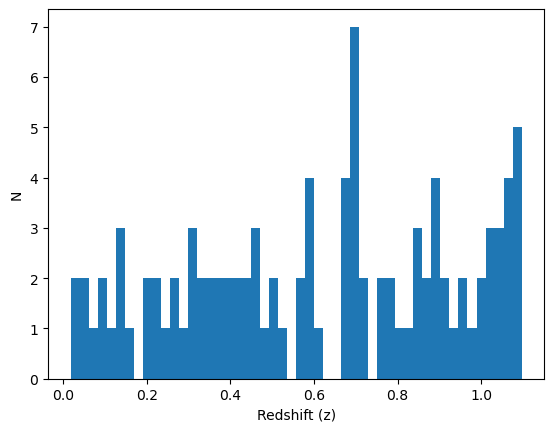

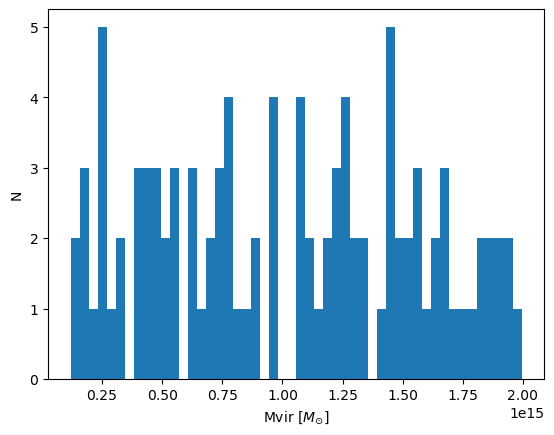

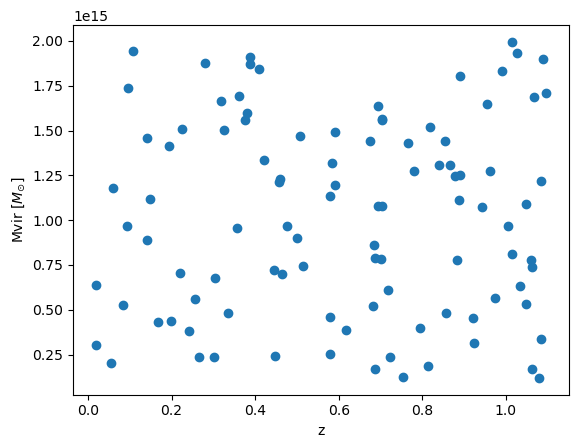

In [105]:
#Generate a new flat z, Mvir distribution and save to file: 
nsources=100 #Number of halos to generate
zdist,mdist=make_dm_halo.flatdist_halo(0.01,1.1,1e14,2e15,nsources) #Generate a flat z, Mvir distribution for sims

plt.hist(zdist,bins=50) #Show the z distribution 
plt.ylabel('N'),plt.xlabel('Redshift (z)')
plt.show()
plt.hist(mdist,bins=50) #Show the M500 distribution 
plt.ylabel('N'),plt.xlabel(r'Mvir [$M_{\odot}$]')
plt.show()
plt.plot(zdist,mdist,'o') #Show the z, M500 scatterplot
plt.xlabel('z'),plt.ylabel(r'Mvir [$M_{\odot}$]')
plt.show()

sourceid=int(time.time()) #Create an initial ctime for the halo ID list to save catalog
idlist=[sourceid+x for x in range(len(zdist))] #Create the halo ID list for catalog

#Save this array to a h5 file
d = h5py.File('massdist.h5', 'w')
d.create_dataset('Redshift', data=zdist)
d.create_dataset('Mass', data=mdist)
d.create_dataset('id', data=idlist)
d.close()

In [7]:
d = h5py.File('massdist.h5', 'r')
zdist = d['Redshift'][:]
midst = d['Mass'][:]
idlist = d['id'][:]
d.close()

In [8]:
r=np.linspace(0.01,10,10000) #arcmin
r=utils.arcmin_to_Mpc(r,0.5,cosmo)

In [9]:
z=0.48
M200=194038855760143.47 #solar masses

In [10]:
(M200,R200,c200)=make_sz_cluster.get_r200_and_c200(cosmo,sigma8,ns,M200,z) #Use M200 to get R200 and concentration from Colossus

In [11]:
P200 = make_sz_cluster.P200_Battaglia2012(cosmo,z,M200,R200) #P200 from Battaglia et al. 2012

In [12]:
P0=make_sz_cluster._P0_Battaglia2012(M200,z) #Parameter computation from Table 1 Battaglia et al. 2012
xc=make_sz_cluster._xc_Battaglia2012(M200,z)
beta=make_sz_cluster._beta_Battaglia2012(M200,z)

In [13]:
Pth=make_sz_cluster.Pth_Battaglia2012(r,R200,-0.3,1.0,beta,xc,P0) #Output Battaglia 2012 pressure profile

In [14]:
Pth_rescaled=(Pth)*(r/R200)**3.

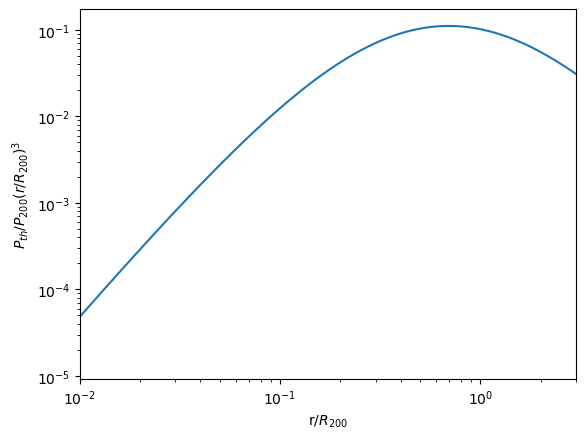

In [15]:
plt.plot(r/R200,Pth_rescaled) #Plot Battaglia 2012 pressure profile
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$P_{th}/P_{200}(r/R_{200})^3$')
plt.xlabel('r/$R_{200}$')
plt.xlim(.010,3)
plt.show()

In [16]:
y = make_sz_cluster.epp_to_y(make_sz_cluster.Pth_Battaglia2012, r, R200_mpc=R200, gamma=-0.3,alpha=1.0,beta=beta,xc=xc,P0=P0, P200_kevcm3=P200)

In [17]:
y[0] #print central y value

2.0780683210418447e-05

In [18]:
fSZ=simtools.f_sz(150,cosmo.Tcmb0) #get f_SZ for observation frequency of 30 GHz
dT=cosmo.Tcmb0*y[0]*fSZ #get dT from y0 using f_SZ
dT=dT.to(u.uK) #Convert to uK
print(dT)

-53.96465340508061 uK


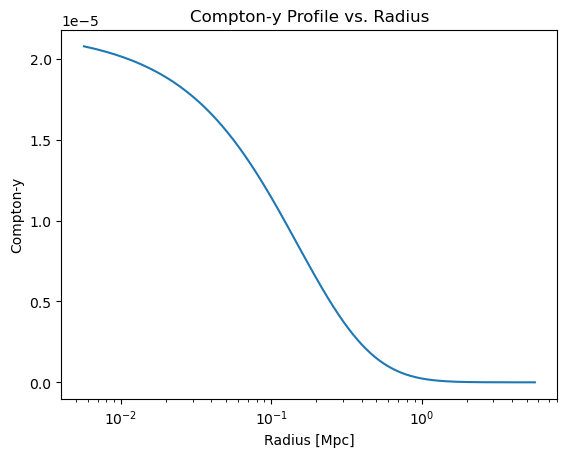

In [19]:
plt.plot(r, y)
plt.xlabel('Radius [Mpc]')
plt.ylabel('Compton-y')
plt.xscale('log')
plt.title('Compton-y Profile vs. Radius')
plt.show()

max:  1.3688133453653876e-05


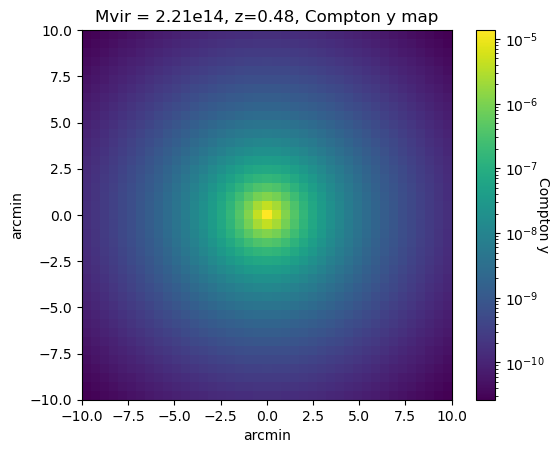

In [61]:
image_size = 41
pix_size = 0.5
y_map = make_sz_cluster._make_y_submap(make_sz_cluster.Pth_Battaglia2012, z, cosmo, image_size, pix_size, R200_mpc=R200, gamma=-0.3,alpha=1.0,beta=beta,xc=xc,P0=P0, P200_kevcm3=P200)
im = plt.imshow(y_map, norm=LogNorm())
cbar = plt.colorbar(im)
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48, Compton y map')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('Compton y', rotation=270)
print('max: ', y_map.max())

max:  35.546250819057946 uK


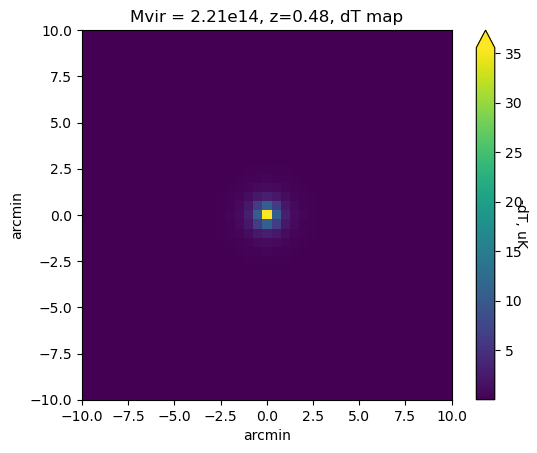

In [62]:
dT_map = (y_map * cosmo.Tcmb0 * -fSZ).to(u.uK)
#noise_map=generate_noise_map(N, 1) * u.uK
im = plt.imshow(dT_map,)
cbar = plt.colorbar(im, extend="max")
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48, dT map')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('-dT, uK', rotation=270)
print("max: ", dT_map.max())

max:  109.0200333657609 uK
min:  47.13564528455862 uK


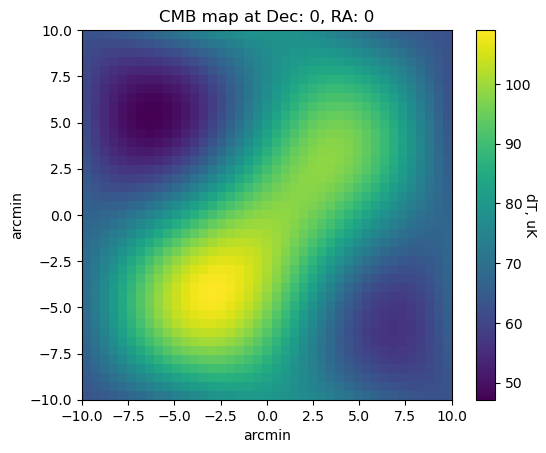

In [63]:
ps = simtools.get_cls(ns=ns, cosmo=cosmo)
cmb_map = simtools.make_cmb_map(shape=y_map.shape, pix_size_arcmin=pix_size, ps=ps)*u.uK
im = plt.imshow(cmb_map)
cbar = plt.colorbar(im)
im.set_extent([-width,width,-width,width])
plt.title('CMB map at Dec: 0, RA: 0')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('dT, uK', rotation=270)
# This is in units of positive uK
print("max: ", cmb_map.max())
print("min: ", cmb_map.min())

max:  -47.13474745928342 uK


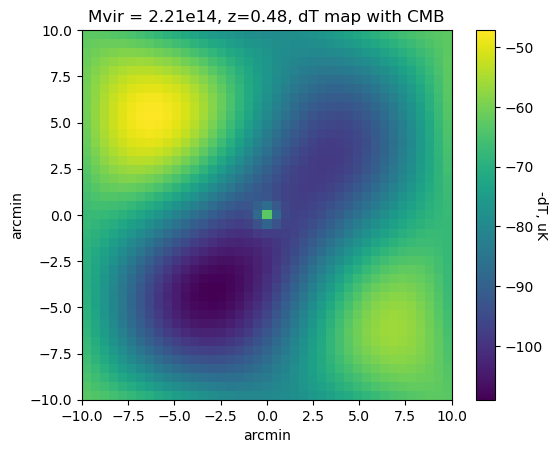

In [64]:
signal_map = dT_map - cmb_map # -(fSZ * y + CMB) 
im = plt.imshow(signal_map)
cbar = plt.colorbar(im)
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48, dT map with CMB')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('-dT, uK', rotation=270)
#This is in units of -uK, to match with the original dT map
print("max: ", signal_map.max())

max:  32.7761057913565


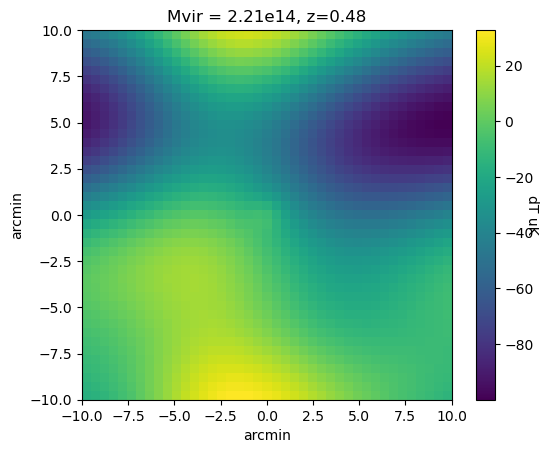

In [65]:
beam_size_fwhp = 1.25
conv_map, _ = simtools.add_cmb_map_and_convolve(dT_map, ps, pix_size, beam_size_fwhp)
im = plt.imshow(conv_map)
cbar = plt.colorbar(im)
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('dT uK', rotation=270)
print('max: ', conv_map.max())

max:  35.546250819057946 uK


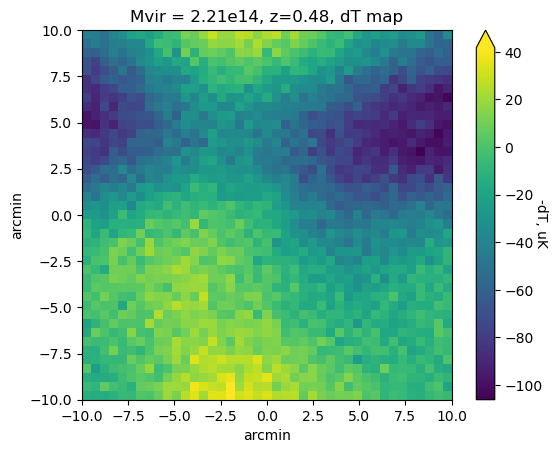

In [67]:
N=41
noise_level =3 
noise_map=noise.generate_noise_map(N, noise_level, pix_size)
total_map=conv_map - noise_map
im = plt.imshow(total_map)
cbar = plt.colorbar(im, extend="max")
im.set_extent([-width,width,-width,width])
plt.title('Mvir = 2.21e14, z=0.48, dT map')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('-dT, uK', rotation=270)
print("max: ", dT_map.max())

In [68]:
noise_level

3

In [28]:
sim_id = 1
# Data to be stored:
data = {
'temperature_submap': dT_map,
'noise_submap' : np.zeros((10,10)),
'cmb_submap' : cmb_map,
'y_central' : y_map[width][width],
'M200': M200,
'redshift_z': z,
'concentration': c200,
'ID': sim_id,
}
with h5py.File('sz_sim_data.h5', 'a') as f:
    utils.save_sim_to_h5(f, f"sim_{sim_id}", data, overwrite=True)

Average in inner radius: -14.319053138909894
Average in outer radius: -19.282551857977243
tSZ signal: 4.963498719067349


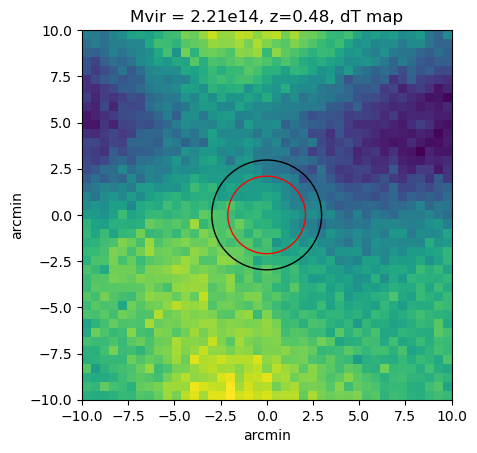

In [69]:
disk, ring, signal = filters.get_tSZ_signal_aperture_photometry(total_map, 2.1)
print('Average in inner radius: '+str(disk))
print('Average in outer radius: '+str(ring))
print('tSZ signal: '+str(signal))
center = np.array(total_map.shape) / 2
center = center - center[0]
fig, ax = plt.subplots()
ax.imshow(total_map, extent=[-width,width,-width,width])
disk_circle = plt.Circle(center, 2.1, color='red', fill=False, linewidth=1)
annulus_circle = plt.Circle(center, 2.1 * np.sqrt(2), color='black', fill=False, linewidth=1)
ax.add_patch(disk_circle)
ax.add_patch(annulus_circle)
cbar = plt.colorbar(im, extend="max")
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('-dT, uK', rotation=270)
plt.title('Mvir = 2.21e14, z=0.48, dT map')
plt.show()


max:  (41, 41)


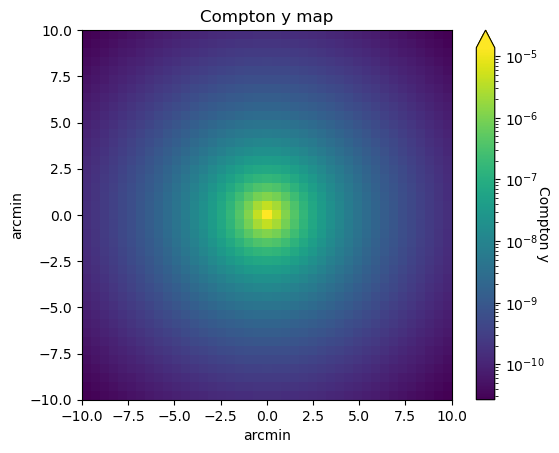

In [70]:
#This is the new function that just generates a submap without having to manually calculate params
y_map = make_sz_cluster.generate_y_submap(z, M200, R200, cosmo, 41, 0.5)
im = plt.imshow(y_map, norm=LogNorm())
cbar = plt.colorbar(im, extend="max")
im.set_extent([-width,width,-width,width])
plt.title('Compton y map')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('Compton y', rotation=270)
print("max: ", y_map.shape)

In [117]:
#This simulates submaps for a distribution, and saves the data to a h5 file, and params to a yaml file
clusters = make_sz_cluster.simulate_submap(mdist, zdist)

9.649876992572175

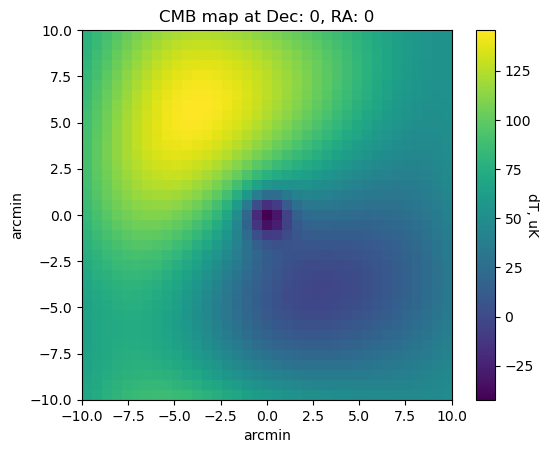

In [111]:
im = plt.imshow(clusters[0]['final_map'] - clusters[0]['noise_map'])
cbar = plt.colorbar(im)
im.set_extent([-width,width,-width,width])
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('dT, uK', rotation=270)
clusters[0]['M200']/1e14